In [218]:
import pandas as pd
import re
import json
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
#import rpy2.robjects as robjects
#from rpy2.robjects import pandas2ri

#### Prepare & Load Data

In [219]:
### Load Data 
gpt3 = "/Users/annaking/Documents/Github/riskychoiceframing_AI/Experiment 2/tests/variable_prompt_test_turbo.csv"
####gpt3 = "/Users/annaking/Documents/Github/riskychoiceframing_AI/Experiment 2/tests/prompt_testing073123_v1.csv"
df_gpt3 = pd.read_csv(gpt3)
df_gpt3.shape

(4462, 8)

In [220]:
##check test runs
df_gpt3.groupby(['test','frame']).size()

test                                                                                               frame      
['combo 1A', 'system_message_baseline1', 'user_message_baseline1', 'system role', 'gain_animal2']  gain_animal      3
['combo 1A', 'system_message_baseline1', 'user_message_baseline1', 'system role']                  gain_animal    102
                                                                                                   gain_forest    105
                                                                                                   gain_human      60
                                                                                                   loss_animal     74
                                                                                                                 ... 
['combo 8C3', 'system_message_1C', 'user_message_4_p', 'instructions: task order & output']        loss_human       2
['combo 8D', 'system_message_1_json', 'user_message_6B2', 'inst

In [221]:
### Cleaning

#clean test names
df_gpt3['test'] = df_gpt3['test'].replace("['combo 7', 'system_message_1D', 'user_message_7']", "['combo 7', 'system_message_1B', 'user_message_7']")
##df_gpt3['test'] = df_gpt3['test'].replace("", "['combo 8C3', 'system_message_1C', 'user_message_4', 'instructions: task order & output']")
df_gpt3['test'] = df_gpt3['test'].replace("['combo 4', 'system_message_4', 'user_message_4']", "['combo 3', 'system_message_risk', 'user_message_baseline1', 'risk system']")
df_gpt3['test'] = df_gpt3['test'].replace("['combo 8A', 'system_message_1C', 'user_message_4', 'instructions: task order & output']", "['combo 2', 'system_message_hum', 'user_message_baseline1', 'human']")
df_gpt3['test'] = df_gpt3['test'].replace("['combo 3', 'system_message_1C', 'user_message_baseline1', 'human']", "['combo 2', 'system_message_hum', 'user_message_baseline1', 'human']")
df_gpt3['test'] = df_gpt3['test'].replace("['combo 4B', 'system_message_4', 'user_message_5']", "['combo 6B', 'system_message_risk', 'user_message_chain', 'risk + chain']")
df_gpt3['test'] = df_gpt3['test'].replace("['combo 9', 'system_message_1', 'user_message_5']", "['combo 6', 'system_message_1', 'user_message_chain', 'flag for re-run']")
df_gpt3['test'] = df_gpt3['test'].replace("['combo 5', 'system_message_baseline1', 'user_message_q1', 'q1 options']", "['combo 7', 'system_message_baseline1', 'user_message_q1', 'q1 options']")
df_gpt3['test'] = df_gpt3['test'].replace("['combo 8D', 'system_message_1_json', 'user_message_6B2', 'instructions: task order & output']", "['combo 5', 'system_message_hum_json', 'user_message_taskord', 'hum + task order']")

conditions1 = (df_gpt3['test'] == "['combo 8', 'system_message_1', 'user_message_4']") & (df_gpt3['temperature'] == .7)
df_gpt3.loc[conditions1, 'test'] = "['combo 2', 'system_message_hum', 'user_message_baseline1', 'human']"

##beg prompt 
pattern = r'(.*?)\s*Scenario:'
df_gpt3['prompt_start'] = df_gpt3['prompt'].str.extract(pattern,  flags=re.DOTALL)
df_gpt3[['frame', 'scenario']] = df_gpt3['frame'].str.split('_', n=1, expand=True)



In [222]:
##drop  tests 
bad_tests = ["['combo 8C', 'system_message_1_json', 'user_message_6B2', 'instructions: task order & output']",
 "['combo 6', 'system_message_1B', 'user_message_6']", 
 "['combo 8C2', 'system_message_1_jsonjp', 'user_message_4_p', 'instructions: task order & output']",
 "['combo 6D', 'system_message_1B', 'user_message_6B']" , ##included too many changes in user message and odd spacing
 "['combo 6B', 'system_message_1C', 'user_message_6B']", ##mismatch in JSON output instructions
 "['combo 7', 'system_message_1B', 'user_message_7']",##odd spacing and mismatch 
 "['combo 6C', 'system_message_1C', 'user_message_6C']", ##mismatch in JSON output instructions; removed options for question 1 
 "['combo 8C3', 'system_message_1C', 'user_message_4_p', 'instructions: task order & output']" ,##included plural responses 
 ###"['combo 9', 'system_message_1', 'user_message_5']", ##mispelling ###not droppping yet
 "['combo 8A', 'system_message_1C', 'user_message_4', 'instructions: task order & output']" ,
 "['combo 8', 'system_message_1', 'user_message_4']",
 ###"['combo 7', 'system_message_hum', 'user_message_q1', 'q1 options']",
 "['combo 7', 'system_message_baseline1', 'user_message_q1', 'q1 options']", 
 "['combo 7', 'system_message_baseline1', 'user_message_noq3', 'hum + simple + noq3']",
 "['combo 5_2', 'system_message_hum_json', 'user_message_taskord_2', 'hum + task order']"	, ### testing the effect of spacing in the sep JSON object
 "['combo 7', 'system_message_hum', 'user_message_noq3', 'hum + simple + noq3']", ##doesnt appear to ahve sig impact 
 "['combo 7B', 'system_message_baseline1', 'user_message_noq3', 'hum + simple + noq3']" ,##doesnt appear to ahve sig impact 
 "['combo 1A', 'system_message_baseline1', 'user_message_baseline1', 'system role', 'gain_animal2']", 
 "['combo 6', 'system_message_1', 'user_message_chain', 'flag for re-run']", ##wrong system message,
 "['combo 2', 'system_message_hum', 'user_message_baseline1', 'human', 'gain_animal3']", ##test for altered animal scenario framing
 "['combo 2', 'system_message_hum', 'user_message_baseline1', 'human', 'loss_forest5']"	,
 "['combo 2', 'system_message_hum', 'user_message_baseline1', 'human', 'loss_forest3']",
 "['combo 2', 'system_message_hum', 'user_message_baseline1', 'human', 'gain_forest2']",	
 "['combo 2', 'system_message_hum', 'user_message_baseline1', 'human', 'gain_forest3']",
 "['combo 2', 'system_message_hum', 'user_message_baseline1', 'human', 'gain_forest4']",
 "['combo 2', 'system_message_hum', 'user_message_baseline1', 'human', 'gain_forest5']"	,
 "['combo 5A', 'system_message_hum', 'user_message_taskord_simp', 'hum + taskordsimp']"	,
 "['combo 7C', 'system_message_hum', 'user_message_q1_options', 'hum + q1_options']" , ## will bring back
"['combo 7', 'system_message_hum', 'user_message_q1', 'q1 options']", 
"['combo 3B', 'system_message_risk', 'user_message_risk', 'hum + risk + risk']" ##should bring back
]## will bring back
df_gpt3 = df_gpt3[~df_gpt3['test'].isin(bad_tests)]

#remove wrong animal gain test
df_gpt3 = df_gpt3[~df_gpt3['prompt'].str.contains('1,000')]

#remove where scenario did not get included 
df_gpt3 = df_gpt3[~df_gpt3['prompt'].str.contains("""{}""")]

#drop accidental test duplicate 
gain_6B_hum_ext = (df_gpt3['test'] == "['combo 6B', 'system_message_risk', 'user_message_chain', 'risk + chain']") & (df_gpt3['scenario'] == 'human') & (df_gpt3['frame'] == 'gain') & (df_gpt3['temperature'] == 0)
loss_6B_hum_ext = (df_gpt3['test'] == "['combo 6B', 'system_message_risk', 'user_message_chain', 'risk + chain']") & (df_gpt3['scenario'] == 'human') & (df_gpt3['frame'] == 'loss') & (df_gpt3['temperature'] == 0)
gain_2_hum_ext = (df_gpt3['test'] == "['combo 2', 'system_message_hum', 'user_message_baseline1', 'human']") & (df_gpt3['scenario'] == 'human') & (df_gpt3['frame'] == 'gain') & (df_gpt3['temperature'] == 0)
gain_3B_hum_ext = (df_gpt3['test'] == "['combo 3B', 'system_message_risk', 'user_message_risk', 'hum + risk + risk']") & (df_gpt3['scenario'] == 'human') & (df_gpt3['frame'] == 'gain') & (df_gpt3['temperature'] == 0)


loss_3_ani_ext = (df_gpt3['test'] == "['combo 3', 'system_message_risk', 'user_message_baseline1', 'risk system']") & (df_gpt3['scenario'] == 'animal') & (df_gpt3['frame'] == 'loss') & (df_gpt3['temperature'] == .7)

loss_5B_for_ext = (df_gpt3['test'] == "['combo 5B', 'system_message_risk_json', 'user_message_taskord', 'risk + task order']") & (df_gpt3['scenario'] == 'forest') & (df_gpt3['frame'] == 'loss') & (df_gpt3['temperature'] == .7)
gain_5B_for_ext = (df_gpt3['test'] == "['combo 5B', 'system_message_risk_json', 'user_message_taskord', 'risk + task order']") & (df_gpt3['scenario'] == 'forest') & (df_gpt3['frame'] == 'gain') & (df_gpt3['temperature'] == .7)
loss_7C_for_ext = (df_gpt3['test'] == "['combo 7C', 'system_message_hum', 'user_message_q1_options', 'hum + q1_options']") & (df_gpt3['scenario'] == 'forest') & (df_gpt3['frame'] == 'loss') & (df_gpt3['temperature'] == 0)
gain_7C_for_ext = (df_gpt3['test'] == "['combo 7C', 'system_message_hum', 'user_message_q1_options', 'hum + q1_options']") & (df_gpt3['scenario'] == 'forest') & (df_gpt3['frame'] == 'gain') & (df_gpt3['temperature'] == 0)
gain_6_for_ext = (df_gpt3['test'] == "['combo 6', 'system_message_hum', 'user_message_chain', 'hum + chain']") & (df_gpt3['scenario'] == 'forest') & (df_gpt3['frame'] == 'gain') & (df_gpt3['temperature'] == 0)
loss_6_for_ext = (df_gpt3['test'] == "['combo 6', 'system_message_hum', 'user_message_chain', 'hum + chain']") & (df_gpt3['scenario'] == 'forest') & (df_gpt3['frame'] == 'loss') & (df_gpt3['temperature'] == 0)


drop_gain_6B_hum_ext = df_gpt3[gain_6B_hum_ext].index[-45:]  
drop_loss_6B_hum_ext = df_gpt3[loss_6B_hum_ext].index[-52:] 
drop_gain_2_hum_ext = df_gpt3[gain_2_hum_ext].index[-2:]  
drop_gain_3B_hum_ext = df_gpt3[gain_3B_hum_ext].index[-7:]  


drop_loss_3_ani_ext = df_gpt3[loss_3_ani_ext].index[-37:]  

drop_gain_5B_for_ext = df_gpt3[gain_5B_for_ext].index[-35:]  
drop_loss_5B_for_ext = df_gpt3[loss_5B_for_ext].index[-28:]  
drop_gain_7C_for_ext = df_gpt3[gain_7C_for_ext].index[-32:]  
drop_loss_7C_for_ext = df_gpt3[loss_7C_for_ext].index[-25:]  
drop_gain_6_for_ext = df_gpt3[gain_6_for_ext].index[-3:]  
drop_loss_6_for_ext = df_gpt3[loss_6_for_ext].index[-3:]  

df_gpt3 = df_gpt3.drop(drop_gain_6B_hum_ext)
df_gpt3 = df_gpt3.drop(drop_loss_6B_hum_ext)
df_gpt3 = df_gpt3.drop(drop_gain_2_hum_ext)
df_gpt3 = df_gpt3.drop(drop_gain_3B_hum_ext)

df_gpt3 = df_gpt3.drop(drop_loss_3_ani_ext)

df_gpt3 = df_gpt3.drop(drop_gain_5B_for_ext)
df_gpt3 = df_gpt3.drop(drop_loss_5B_for_ext)
df_gpt3 = df_gpt3.drop(drop_gain_7C_for_ext)
df_gpt3 = df_gpt3.drop(drop_loss_7C_for_ext)
df_gpt3 = df_gpt3.drop(drop_gain_6_for_ext)
df_gpt3 = df_gpt3.drop(drop_loss_6_for_ext)

In [74]:
df_gpt3.shape

(2830, 10)

In [223]:
##clean json 
# import json 
def clean_json(x):
    x = x.strip("'")  # remove leading/trailing single quotes
    x = x.strip("\n")  # remove leading/trailing newline characters
    x = x.encode('utf-8', 'ignore').decode('utf-8')  # ignore non utf-8 characters
    x = re.sub(r'"\s*"', '","', x)  # replace spaces between quotes with commas
    #replace incorrect JSON keys with correct keys
    for key in ["Q1_Response", "Q2_Response", "Q3_Response"]:
        x = re.sub(f'(?<=[{{,])\s*{key}\s*(?=:)', f' "{key}"', x)
    # make sure quotes 
    x = re.sub(r':\s*([0-9]+)\s*(?=[,}])', r': "\1"', x)

    # cleaning steps
    x = x.replace('Q1_response','Q1_Response')
    x = x.replace('Q2_response','Q2_Response')
    x = x.replace('Q3_response','Q3_Response')
    x = x.replace('it"s', 'it\'s')
    x = x.replace('B"s', "B's")
    x = x.replace("}, {", ",")
    x = x.replace("},{", ",")

    for proposal in ["Proposal A", "Proposal B"]:
        x = re.sub(f'(?<=:)\s*{proposal}(?=\s*[^"]\w*,)', f' "{proposal}"', x)
    x = re.sub(r'}\s*{', ', ', x)
    if not x.startswith('{'):
        x = '{' + x
    if not x.endswith('}'):
        x = x + '}'
    try:
        x = x.replace('\n', ' ')
        x = json.dumps(json.loads(x))
    except json.JSONDecodeError:
        return x
    return x

def try_loads(x):
    try:
        return pd.Series(json.loads(x))
    except json.JSONDecodeError:
        print(f"Error decoding: {x}")
        return pd.Series()

df_gpt3['response'] = df_gpt3['response'].apply(clean_json)
responses = df_gpt3.apply(lambda x: pd.Series(json.loads(x['response'])), axis=1, result_type='expand')
df_gpt3 = pd.concat([df_gpt3, responses], axis = 1)
df_gpt3 = df_gpt3.reset_index()
df_gpt3['Q1_Response']  = df_gpt3['Q1_Response'].apply(lambda x: 'Proposal B' if x == 'Option B' else x)
df_gpt3['Q1_Response']  = df_gpt3['Q1_Response'].apply(lambda x: 'Proposal A' if x == 'Option A' else x)
df_gpt3 = df_gpt3[~df_gpt3['Q2_Response'].isna()]

###responses = df_gpt3['response'].apply(try_loads)

In [224]:
##define variables for each test 
import ast
test_dict = {
    "['combo 1A', 'system_message_baseline1', 'user_message_baseline1', 'system role']": "['neutral_system','simple','neutral_risk']",
    "['combo 2', 'system_message_hum', 'user_message_baseline1', 'human']":"['human','simple', 'neutral_risk']",
    "['combo 3', 'system_message_risk', 'user_message_baseline1', 'risk system']":"['human','simple', 'risk']",  
    "['combo 5', 'system_message_hum_json', 'user_message_taskord', 'hum + task order']": "['human','task_order', 'neutral_risk']",
    "['combo 5B', 'system_message_risk_json', 'user_message_taskord', 'risk + task order']": "['human','task_order', 'risk']",
    "['combo 6', 'system_message_1', 'user_message_chain', 'flag for re-run']": "['human','chain','neutral_risk' ]",
    "['combo 6', 'system_mčssage_hum', 'user_message_chain', 'hum + chain']": "['human','chain','neutral_risk' ]",
    "['combo 6B', 'system_message_risk', 'user_message_chain', 'risk + chain']": "['human','chain','risk']"
    }

var_dict = {'sys_role': ['human', 'neutral_system'],
            'instructions': ['simple', 'chain', 'task_order'],
            'risk': ['neutral_risk', 'risk']}


new_test_dict = {}
for key, value in test_dict.items():
    new_key = ast.literal_eval(key)
    new_value = ast.literal_eval(value)
    new_test_dict[tuple(new_key)] = new_value


def map_values(test_name):
    # Dictionary to hold our results
    result = {}
    test_list = ast.literal_eval(test_name)
    variable_list = test_dict.get(test_name, [])
    
    # Iterate over the variable dictionary
    for var_type, values in var_dict.items():
        # Check if any value from var_dict is in the variable_list
        for val in values:
            if val in variable_list:
                result[var_type] = val
                break  # break once we find a match
                
    # Return as a Series
    return pd.Series(result)
df_gpt3 = df_gpt3.join(df_gpt3['test'].apply(map_values))

##order into dummies 
ins = ['simple', 'chain', 'task_order']
sys = ['human', 'neutral_system']
rsk = ['neutral_risk', 'risk']

df_gpt3['instructions'] = df_gpt3['instructions'].astype('category').cat.reorder_categories(ins, ordered=True)
df_gpt3['sys_role'] = df_gpt3['sys_role'].astype('category').cat.reorder_categories(sys, ordered=True)
df_gpt3['risk'] = df_gpt3['risk'].astype('category').cat.reorder_categories(rsk, ordered=True)


In [161]:
df_gpt3['test_name'] =(df_gpt3['sys_role'], df_gpt3['instructions'], df_gpt3['risk'])

ValueError: Length of values (3) does not match length of index (2818)

In [225]:
#Clean Dependent Variables
import re
#Option Selected
df_gpt3['option_selected'] =  df_gpt3['Q1_Response']

#Rating Number
df_gpt3['Q2_Response'] = df_gpt3['Q2_Response'].astype('str')
df_gpt3['rating_num'] = df_gpt3['Q2_Response'].str.extract(r'(\d+)')
df_gpt3['rating_num'] = df_gpt3['rating_num'].astype('int')


##categorize
ratings =  { 'Strong Preference for Proposal A': 1, 2: 'Preference for Proposal A', 3:'Slight Preference for Proposal A',  4:'No Preference for Proposal A or B',  5:'Slight Preference for Propsal B',  6:'Preference for Proposal B',7:'Strong Preference for Proposal B'}
##df_gpt3['rating_num'] = pd.to_numeric(df_gpt3['rating_num'], errors='coerce')
##df_gpt3['rating_cat'] = df_gpt3['rating_num'].map(ratings)
###df_gpt3 = df_gpt3[~df_gpt3['rating_num'].isna()]
##df_gpt3['rating_cat'] = df_gpt3['rating_num'].map(ratings)


In [258]:
### Create Dummy Variables 
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

##prompt variables 
df_gpt3['sys_role'] = df_gpt3['sys_role'].astype(pd.CategoricalDtype(categories=['neutral_system', 'human'], ordered=True))

sys_role_dummy = pd.get_dummies(df_gpt3['sys_role'], prefix='sys_role', drop_first=True)
instructions_dummy  = pd.get_dummies(df_gpt3['instructions'], prefix='instructions', drop_first=True)
risk_dummy = pd.get_dummies(df_gpt3['risk'], prefix='risk', drop_first=True)

#create variables for dep. and indp. 
df_gpt3['frame_gain'] = (df_gpt3['frame'] == 'gain').astype(int)
df_gpt3['option_selected_B'] = le.fit_transform(df_gpt3['option_selected']) ##0 = Prop A, 1 = Prop B
df_gpt3['option_selected_A'] = 1 - df_gpt3['option_selected_B']  ## Reversing the encoding
df_gpt3['scenario_c'] = df_gpt3['scenario'].astype(pd.CategoricalDtype(categories=['forest', 'animal', 'human'], ordered=True))
df_gpt3['reversed_rating_num'] = 8 - df_gpt3['rating_num']


In [206]:
##save for cross compare 
df_gpt3.to_csv('df_gpt3.csv')

#### Look at each Test Result

In [118]:
##Choice Cross tab 
pd.set_option('display.max_colwidth', None)

t0 = df_gpt3[df_gpt3['temperature'] == 0 ]
t7 = df_gpt3[df_gpt3['temperature'] == .7 ]

#t7_ct = pd.crosstab([t7['test'] ,t7['scenario'] ] ,[t7['frame'], t7['Q1_Response']]) ###
#t0_ct = pd.crosstab([t0['test'] ,t0['scenario'] ] ,[t0['frame'], t0['Q1_Response']])
#t0_ct = pd.crosstab([t0['test'] ] ,[t0['frame'], t0['Q1_Response']])
t0_ct = pd.crosstab(t0['frame'], t0['Q1_Response'], normalize='index').reset_index()

t0_ct.round(4)

Q1_Response,frame,Proposal A,Proposal B
0,gain,0.2909,0.7091
1,loss,0.5416,0.4584


In [ ]:
###Archive -- new columns 

new_columns = []
for column in df_cross_tab.columns:
    if isinstance(column, tuple):  # this will be true for the temperature-related columns
        if column[0] == 0.0 and column[1] == 'Proposal A':
            new_columns.append('PA_t0')
        elif column[0] == 0.0 and column[1] == 'Proposal B':
            new_columns.append('PB_t0')
        elif column[0] == 0.7 and column[1] == 'Proposal A':
            new_columns.append('PA_t.7')
        elif column[0] == 0.7 and column[1] == 'Proposal B':
            new_columns.append('PB_t.7')
        elif column[0] == 1 and column[1] == 'Proposal A':
            new_columns.append('PA_t1')
        else: 
             new_columns.append('PB_t1')
    else:  # this will be true for 'test' and 'frame' columns
        new_columns.append(column)
df_cross_tab.columns = new_columns
df_cross_tab.reset_index(inplace=True)
df_cross_tab

In [119]:
###Prop A Crosstab
df_cross_tab['PA_t0_pct'] = (df_cross_tab['PA_t0'] / (df_cross_tab['PA_t0'] + df_cross_tab['PB_t0']))*100
df_cross_tab['PA_t0_pct'] = df_cross_tab['PA_t0_pct'].round(2)
##df_cross_tab['PA_t1_pct'] = (df_cross_tab['PA_t1'] / (df_cross_tab['PA_t1'] + df_cross_tab['PB_t1']))
##df_cross_tab['PA_t1_pct'] = df_cross_tab['PA_t1_pct'].round(2)
df_cross_tab['PA_t.7_pct'] = (df_cross_tab['PA_t.7'] / (df_cross_tab['PA_t.7'] + df_cross_tab['PB_t.7']))*100
df_cross_tab['PA_t.7_pct'] = df_cross_tab['PA_t.7_pct'].round(2)
###prop_A = df_cross_tab.drop(columns = ['PA_t0','PB_t0', 'PA_t.7', 'PB_t.7', 'PA_t1', 'PB_t1'])
prop_A = df_cross_tab.drop(columns = ['PA_t0','PB_t0', 'PA_t.7', 'PB_t.7'])
prop_A

,test,frame,PA_t0_pct,PA_t.7_pct
0,"['combo 1A', 'system_message_baseline1', 'user_message_baseline1', 'system role']",gain,30.30,34.34
1,"['combo 1A', 'system_message_baseline1', 'user_message_baseline1', 'system role']",loss,72.55,64.71
2,"['combo 2', 'system_message_hum', 'user_message_baseline1', 'human']",gain,30.30,36.36
3,"['combo 2', 'system_message_hum', 'user_message_baseline1', 'human']",loss,72.55,51.96
4,"['combo 3', 'system_message_risk', 'user_message_baseline1', 'risk system']",gain,30.30,35.35
5,"['combo 3', 'system_message_risk', 'user_message_baseline1', 'risk system']",loss,72.55,59.80
6,"['combo 3B', 'system_message_risk', 'user_message_risk', 'hum + risk + risk']",gain,96.97,NaN
7,"['combo 3B', 'system_message_risk', 'user_message_risk', 'hum + risk + risk']",loss,72.55,NaN
8,"['combo 5', 'system_message_hum_json', 'user_message_taskord', 'hum + task order']",gain,4.04,26.26
9,"['combo 5', 'system_message_hum_json', 'user_message_taskord', 'hum + task order']",loss,0.00,44.12


In [129]:
sixb = df_gpt3[df_gpt3['test'] == "['combo 6', 'system_message_hum', 'user_message_chain', 'hum + chain']"]

sixb.groupby(['temperature']).size()

temperature
0.0    201
dtype: int64

In [121]:
##Rating Crosstab
rating_cross_t0 = pd.crosstab(df_gpt3['test'] ,[df_gpt3['temperature'],df_gpt3['frame']], values = df_gpt3['rating_num'], aggfunc= 'mean')
rating_cross_t0.round(2)

temperature                                                                             0.0  \
frame                                                                                  gain   
test                                                                                          
['combo 1A', 'system_message_baseline1', 'user_message_baseline1', 'system role']      4.79   
['combo 2', 'system_message_hum', 'user_message_baseline1', 'human']                   4.79   
['combo 3', 'system_message_risk', 'user_message_baseline1', 'risk system']            4.79   
['combo 3B', 'system_message_risk', 'user_message_risk', 'hum + risk + risk']          2.13   
['combo 5', 'system_message_hum_json', 'user_message_taskord', 'hum + task order']     6.49   
['combo 5B', 'system_message_risk_json', 'user_message_taskord', 'risk + task order']  5.53   
['combo 6', 'system_message_hum', 'user_message_chain', 'hum + chain']                 6.08   
['combo 6B', 'system_message_risk', 'user_message_chain', 'risk + chain']              4.14   
['combo 7', 'system_message_baseline1', 'user_message_noq3', 'hum + simple + noq3']    2.00   

temperature                                                                                  \
frame                                                                                  loss   
test                                                                                          
['combo 1A', 'system_message_baseline1', 'user_message_baseline1', 'system role']      3.10   
['combo 2', 'system_message_hum', 'user_message_baseline1', 'human']                   3.10   
['combo 3', 'system_message_risk', 'user_message_baseline1', 'risk system']            3.10   
['combo 3B', 'system_message_risk', 'user_message_risk', 'hum + risk + risk']          3.10   
['combo 5', 'system_message_hum_json', 'user_message_taskord', 'hum + task order']     7.00   
['combo 5B', 'system_message_risk_json', 'user_message_taskord', 'risk + task order']  5.05   
['combo 6', 'system_message_hum', 'user_message_chain', 'hum + chain']                 4.70   
['combo 6B', 'system_message_risk', 'user_message_chain', 'risk + chain']              3.19   
['combo 7', 'system_message_baseline1', 'user_message_noq3', 'hum + simple + noq3']    2.00   

temperature                                                                             0.7  \
frame                                                                                  gain   
test                                                                                          
['combo 1A', 'system_message_baseline1', 'user_message_baseline1', 'system role']      4.69   
['combo 2', 'system_message_hum', 'user_message_baseline1', 'human']                   4.73   
['combo 3', 'system_message_risk', 'user_message_baseline1', 'risk system']            4.46   
['combo 3B', 'system_message_risk', 'user_message_risk', 'hum + risk + risk']           NaN   
['combo 5', 'system_message_hum_json', 'user_message_taskord', 'hum + task order']     5.12   
['combo 5B', 'system_message_risk_json', 'user_message_taskord', 'risk + task order']  4.68   
['combo 6', 'system_message_hum', 'user_message_chain', 'hum + chain']                  NaN   
['combo 6B', 'system_message_risk', 'user_message_chain', 'risk + chain']              4.45   
['combo 7', 'system_message_baseline1', 'user_message_noq3', 'hum + simple + noq3']     NaN   

temperature                                                                                  
frame                                                                                  loss  
test                                                                                         
['combo 1A', 'system_message_baseline1', 'user_message_baseline1', 'system role']      3.72  
['combo 2', 'system_message_hum', 'user_message_baseline1', 'human']                   4.16  
['combo 3', 'system_message_risk', 'user_message_baseline1', 'risk system']            3.83  
['combo 3B', 

#### Descriptive Stats

In [35]:
print(df_gpt3['option_selected'].value_counts(normalize=True))
print('\n\n')
print(df_gpt3.groupby('frame')['option_selected'].value_counts(normalize=True))

option_selected
Proposal A    0.605655
Proposal B    0.394345
Name: proportion, dtype: float64



frame  option_selected
gain   Proposal B         0.501534
       Proposal A         0.498466
loss   Proposal A         0.706647
       Proposal B         0.293353
Name: proportion, dtype: float64


<Axes: xlabel='rating_num', ylabel='Count'>

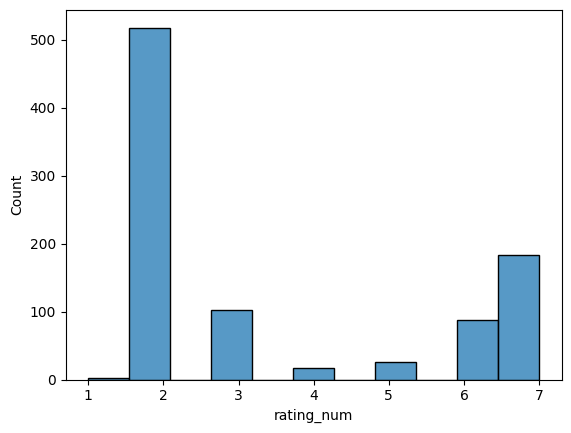

In [404]:
##Graphing

sns.histplot(df_gpt3['rating_num'])

In [ ]:
##histogram of probabilites 
import seaborn as sns
##proba = 1 / (1 + np.exp( - logit_reg_rev.fittedvalues ))
sns.histplot(proba)

### Hypothesis Testing

- H4: GPT-3.5 Turbo will also exhibit a framing effect, mirroring the tendencies observed in human decision-making.
- H5: The scenario will influence the strength of the framing effect in GPT-3.5 Turbo's choices.
- H6: The model prompt conditions (risk, system role, and instructions) will moderate the framing effect observed in GPT-3.5 Turbo's choices.
- H7: A higher temperature (0.7) will introduce more randomness in GPT-3.5 Turbo's responses, leading to a weaker or less consistent framing effect.
- H8: The scenario will have an interaction effect with the frame (gain/loss) on the choices made by the GPT-3.5 Turbo model.

#### Stat Tests for Hypotheses

H1 & H2: Framing Effect and Preference Ratings

In [130]:
###H1: Chi-squared Test (or Fisher's Exact Test) for Option Selected:
contingency_table = pd.crosstab(df_gpt3['frame'], df_gpt3['option_selected'])
chi2, pval, _, _ = stats.chi2_contingency(contingency_table)

###H2: Kruskal-Wallis Test for Rating ##CHECK
stat, p_val2 = stats.mannwhitneyu(df_gpt3[df_gpt3['frame']=='gain']['rating_num'], df_gpt3[df_gpt3['frame']=='loss']['rating_num'])


###Output as a table
results = {
    ('option selected'): {
        'chi2/stat': chi2,
        'p_val': pval,
        'sig effect': pval < .05
    },
    ('rating number'): {
        'chi2/stat': stat,
        'p_val': p_val2,
        'sig effect': p_val2 < .05
    }}

df_op = pd.DataFrame.from_dict(results)
df_op



,option selected,rating number
chi2/stat,163.277173,1163582.0
p_val,0.0,0.0
sig effect,True,True


H3 - H5: Influence of Prompt 

In [131]:
############## ---- Instructions ---- ###############
#Instructions (Op Selected)
ins_cont_table = pd.crosstab(df_gpt3['instructions'], df_gpt3['option_selected'])
chi2_i, pval_i, _, _ = stats.chi2_contingency(ins_cont_table)
#Instructions (Rating)
stat_i, pval_i2 = stats.kruskal(df_gpt3[df_gpt3['instructions']=='simple']['rating_num'], df_gpt3[df_gpt3['instructions']=='chain']['rating_num'], df_gpt3[df_gpt3['instructions']=='task_order']['rating_num'])

############## ---- System Role ---- ###############

#Sys Role (Op Selected)
sys_cont_table = pd.crosstab(df_gpt3['sys_role'], df_gpt3['option_selected'])
chi2_s, pval_s, _, _ = stats.chi2_contingency(ins_cont_table)
#Sys Rol (Rating)
stat_s, pval_s2= stats.kruskal(df_gpt3[df_gpt3['sys_role']=='neutral']['rating_num'], df_gpt3[df_gpt3['sys_role']=='human']['rating_num'])

############## ---- Risk ---- ###############

#Risk (Op Selected)
risk_cont_table = pd.crosstab(df_gpt3['risk'], df_gpt3['option_selected'])
chi2_r, pval_r, _, _ = stats.chi2_contingency(ins_cont_table)
#Risk (Rating)
stat_r, pval_r2= stats.kruskal(df_gpt3[df_gpt3['risk']=='neutral']['rating_num'], df_gpt3[df_gpt3['risk']=='risk']['rating_num'])

############## ---- Temp ---- ###############
#Temp (Op Selected)
risk_cont_table = pd.crosstab(df_gpt3['temperature'], df_gpt3['option_selected'])
chi2_t, pval_t, _, _ = stats.chi2_contingency(ins_cont_table)
#Temp (Rating)
stat_t, pval_t2= stats.kruskal(df_gpt3[df_gpt3['temperature']==0]['rating_num'], df_gpt3[df_gpt3['temperature']==.7]['rating_num'])

In [132]:
###Output as a table
dict_instructions = {
    ('instructions', 'option selected'): {
        'chi2/stat': chi2_i,
        'p_val': pval_i,
        'sig effect': pval_i < .05
    },
    ('instructions', 'rating number'): {
        'chi2/stat': stat_i,
        'p_val': pval_i2,
        'sig effect': pval_i2 < .05
    }
}
dict_sys_role = {
    ('sys role', 'option selected'): {
        'chi2/stat': chi2_s,
        'p_val': pval_s,
        'sig effect': pval_s < .05
    },
    ('sys role', 'rating number'): {
        'chi2/stat': stat_s,
        'p_val': pval_s2,
        'sig effect': pval_s2 < .05
    }
}
dict_risk = {
    ('risk', 'option selected'): {
        'chi2/stat': chi2_r,
        'p_val': pval_r,
        'sig effect': pval_r < .05
    },
    ('risk', 'rating number'): {
        'chi2/stat': stat_r,
        'p_val': pval_r2,
        'sig effect': pval_r2 < .05
    }
}
dict_temp = {
    ('temp', 'option selected'): {
        'chi2/stat': chi2_t,
        'p_val': pval_t,
        'sig effect': pval_t < .05
    },
    ('temp', 'rating number'): {
        'chi2/stat': stat_t,
        'p_val': pval_t2,
        'sig effect': pval_t2 < .05,
    }
}
df_instructions = pd.DataFrame(dict_instructions)
df_sys_role = pd.DataFrame(dict_sys_role)
df_risk = pd.DataFrame(dict_risk)
df_temp = pd.DataFrame(dict_temp)
test_results_df = pd.concat([df_instructions, df_sys_role, df_risk, df_temp], axis=1)


#### Regression Tests for Hypotheses 

In [227]:
##prep variables 
from sklearn import preprocessing
le = preprocessing.LabelEncoder()


##data cleaning & dummy coding 
df_gpt3_w_dummy = pd.get_dummies(df_gpt3, columns=['test'], prefix='participant_type', drop_first=True)
    #participant_type_['combo 2', 'system_message_hum', 'user_message_baseline1', 'human']	
    #participant_type_['combo 3', 'system_message_risk', 'user_message_baseline1', 'risk system']	   
    #participant_type_['combo 5', 'system_message_hum_json', 'user_message_taskord', 'hum + task order']	
    #participant_type_['combo 5B', 'system_message_risk_json', 'user_message_taskord', 'risk + task order']		
    #participant_type_['combo 6', 'system_message_1', 'user_message_chain', 'flag for re-run']	
    #participant_type_['combo 6B', 'system_message_risk', 'user_message_chain', 'risk + chain']
    
##cat code temperature variable 

##rename variables for 
df_gpt3_w_dummy= df_gpt3_w_dummy.rename(columns = {
    "participant_type_['combo 2', 'system_message_hum', 'user_message_baseline1', 'human']":'human', 
    "participant_type_['combo 3', 'system_message_risk', 'user_message_baseline1', 'risk system']": 'hum_risk',
    "participant_type_['combo 5', 'system_message_hum_json', 'user_message_taskord', 'hum + task order']": 'hum_taskord',
    "participant_type_['combo 5B', 'system_message_risk_json', 'user_message_taskord', 'risk + task order']": 'hum_risk_taskord',
    "participant_type_['combo 6', 'system_message_1', 'user_message_chain', 'flag for re-run']": 'hum_chain',
    "participant_type_['combo 6B', 'system_message_risk', 'user_message_chain', 'risk + chain']": 'hum_risk_chain'
    })
##dummy_cols = ['human', 'hum_risk', 'hum_taskord', 'hum_risk_taskord', 'hum_chain', 'hum_risk_chain']
##df_gpt3_w_dummy[dummy_cols] = df_gpt3_w_dummy[dummy_cols].astype(int)

df_gpt3['temp_var'] = df_gpt3.temperature.astype('category').cat.codes ##temp 0 = 0; temp .7 = 1


R[write to console]: trying URL 'https://cran.r-project.org/bin/macosx/big-sur-arm64/contrib/4.2/stargazer_5.2.3.tgz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 616438 bytes (601 KB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to cons


The downloaded binary packages are in
	/var/folders/vv/15vmsdzj0d9c0x2z42fx60fr0000gn/T//RtmplKPxdU/downloaded_packages


R[write to console]: 
Please cite as: 


R[write to console]:  Hlavac, Marek (2022). stargazer: Well-Formatted Regression and Summary Statistics Tables.

R[write to console]:  R package version 5.2.3. https://CRAN.R-project.org/package=stargazer 




'stargazer','tools','stats',...,'datasets','methods','base'


In [17]:
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
pandas2ri.activate()

### R Packages
##R = robjects.r
##robjects.r('options(repos = c(CRAN="https://cran.r-project.org/"))')
##robjects.r('install.packages("ggplot2")')
##robjects.r('install.packages("glm")')
##R('library(glm)')
#robjects.r('install.packages("broom", repos="https://cran.r-project.org/")')
#robjects.r('library(broom)')
##robjects.r('install.packages("stargazer", repos="https://cran.r-project.org/")')
##robjects.r('library(stargazer)')



R = robjects.r

df_gpt3_r = pandas2ri.py2rpy(df_gpt3)


formula = 'option_selected_cat ~ frame_cat'
model = R.glm(formula, data=df_gpt3, family="binomial")
summary_output = robjects.r('stargazer')(model, type="text")
print(summary_output[0])



R[write to console]: Error in if (is.na(s)) { : the condition has length > 1



RRuntimeError: Error in if (is.na(s)) { : the condition has length > 1


In [228]:
##sep conditions for gain and loss 
gain_cond = df_gpt3[df_gpt3['frame'] == 'gain']
loss_cond = df_gpt3[df_gpt3['frame'] == 'loss']
##crete df for each test 
tests = {f'df_{test}': df_gpt3[df_gpt3['test'] == test] for test in df_gpt3['test'].unique()}
for key in tests.keys():
    print(key)

df_['combo 2', 'system_message_hum', 'user_message_baseline1', 'human']
df_['combo 3', 'system_message_risk', 'user_message_baseline1', 'risk system']
df_['combo 6B', 'system_message_risk', 'user_message_chain', 'risk + chain']
df_['combo 5', 'system_message_hum_json', 'user_message_taskord', 'hum + task order']
df_['combo 1A', 'system_message_baseline1', 'user_message_baseline1', 'system role']
df_['combo 5B', 'system_message_risk_json', 'user_message_taskord', 'risk + task order']
df_['combo 6', 'system_message_hum', 'user_message_chain', 'hum + chain']


##### Logit Regression (Hyp 1)

Hypothesis 1.1: All AI models will exhibit the framing effect.

In [248]:
####Simple Regression Model 
##frame_gain: 0 = loss, 1 = gain
##frame_cat: 0 = gain, 1 = loss
#option_selected_rev: 0 = B; 1 = A
#option_selected_cat: 0 = A; 1 = B


#Simple
logit_reg = smf.logit('option_selected_A ~ frame_gain', df_gpt3).fit()
print(logit_reg.summary())
# the likelihood (in log-odds) of choosing option A decreases compared to the loss frame.

##Scenario  
logit_reg_scn = smf.logit('option_selected_A ~ frame_gain + C(scenario)', df_gpt3).fit()
print(logit_reg_scn.summary())

## Temp 
logit_reg_temp = smf.logit('option_selected_A ~ frame_gain + C(temperature)', df_gpt3).fit()
print(logit_reg_temp.summary())

## Model Variables 
logit_reg_var= smf.logit('option_selected_A ~ frame_gain + C(instructions) + C(risk) + C(sys_role)', df_gpt3).fit()
print(logit_reg_var.summary())

##Scenario + Temp
logit_reg_scn_temp = smf.logit('option_selected_A ~ frame_gain + C(scenario) + C(temperature)', df_gpt3).fit()
print(logit_reg_scn_temp.summary())

##Scenario + Temp + Test
logit_reg_scn_temp_test = smf.logit('option_selected_A ~ frame_gain + C(scenario) + C(temperature) + C(test)', df_gpt3).fit()
print(logit_reg_scn_temp_test.summary())

##Scenario + Temp + Model Variables 
logit_reg_scn_temp_test_var = smf.logit('option_selected_A ~ frame_gain + C(scenario) + C(temperature) + C(instructions) + C(risk) + C(sys_role)', df_gpt3).fit()
print(logit_reg_scn_temp_test_var.summary())

#### Interaction 
#Scenario  
logit_int_scn = smf.logit('option_selected_A ~ frame_gain * C(scenario) + frame_gain', df_gpt3).fit()
print(logit_int_scn.summary())

##Scenario + Temp
logit_int_scn_temp = smf.logit('option_selected_A ~ frame_gain * C(scenario) + frame_gain *  C(temperature) + frame_gain', df_gpt3).fit()
print(logit_int_scn_temp.summary())

##Scenario + Temp + Test
logit_int_scn_temp_test = smf.logit('option_selected_A ~ frame_gain  * C(scenario) + frame_gain *  C(temperature) + frame_gain ', df_gpt3).fit()
print(logit_int_scn_temp_test.summary())

##Model Variables 
logit_int_scn_temp_test = smf.logit('option_selected_A ~ frame_gain  * C(instructions) + frame_gain *  C(sys_role) + frame_gain *  C(risk) + frame_gain ', df_gpt3).fit()
print(logit_int_scn_temp_test.summary())

##add in interaction term for temp & model 

logit_reg_temptest = smf.logit('option_selected_A ~ frame_gain * test + frame * temperature ', df_gpt3).fit()
logit_reg_temptest.summary()

Optimization terminated successfully.
         Current function value: 0.635516
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:      option_selected_A   No. Observations:                 2814
Model:                          Logit   Df Residuals:                     2812
Method:                           MLE   Df Model:                            1
Date:                Mon, 14 Aug 2023   Pseudo R-squ.:                 0.05539
Time:                        18:31:56   Log-Likelihood:                -1788.3
converged:                       True   LL-Null:                       -1893.2
Covariance Type:            nonrobust   LLR p-value:                 1.579e-47
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1206      0.053      2.274      0.023       0.017       0.225
frame_gain    -1.1418      0.

/Users/annaking/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:      option_selected_A   No. Observations:                 2814
Model:                          Logit   Df Residuals:                     2797
Method:                           MLE   Df Model:                           16
Date:                Mon, 14 Aug 2023   Pseudo R-squ.:                  0.1243
Time:                        18:31:58   Log-Likelihood:                -1657.9
converged:                      False   LL-Null:                       -1893.2
Covariance Type:            nonrobust   LLR p-value:                 5.387e-90
============================================================================================================================================================================
                                                                                                               coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                                   -0.1499        nan        nan        nan         nan         nan
test[T.['combo 2', 'system_message_hum', 'user_message_baseline1', 'human']]                                -0.2827      0.209     -1.353      0.176      -0.692       0.127
test[T.['combo 3', 'system_message_risk', 'user_message_baseline1', 'risk system']]                         -0.1117      0.211     -0.528      0.597      -0.526       0.303
test[T.['combo 5', 'system_message_hum_json', 'user_message_taskord', 'hum + task order']]                  -2.0475      0.227     -9.036      0.000      -2.492      -1.603
test[T.['combo 5B', 'system_message_risk_json', 'user_message_taskord', 'risk + task order']]               -1.1612      0.208     -5.591      0.000      -1.568      -0.754
test[T.['combo 6', 'system_message_hum', 'user_message_chain', 'hum + chain']]                              -1.1816      0.208     -5.684      0.000      -1.589      -0.774
test[T.['combo 6B', 'system_message_risk', 'user_message_chain', 'risk + chain']]                            0.1166      0.216      0.540      0.589      -0.307       0.540
frame[T.loss]                                                                                                0.8601        nan        nan        nan         nan         nan
frame_gain                                                                                                  -1.0104        nan        nan        nan         nan         nan
frame_gain:test[T.['combo 2', 'system_message_hum', 'user_message_baseline1', 'human']]                      0.3301      0.302      1.094      0.274      -0.261       0.922
frame_gain:test[T.['combo 3', 'system_message_risk', 'user_message_baseline1', 'risk system']]               0.1355      0.304      0.446      0.656      -0.460       0.731
frame_gain:test[T.['combo 5', 'system_message_hum_json', 'user_message_taskord', 'hum + task order']]        1.0376      0.340      3.056      0.002       0.372       1.703
frame_gain:test[T.['combo 5B', 'system_message_risk_json', 'user_message_taskord', 'risk + task order']]     0.5710      0.313      1.824      0.068      -0.043       1.185
frame_gain:test[T.['combo 6', 'system_message_hum', 'user_message_chain', 'hum + chain']]                    0.3598      0.320      1.123      0.261      -0.268       0.988
frame_gain:test[T.['combo 6B', 'system_message_risk', 'user_message_chain', 'risk + chain']]                -0.0928      0.307     -0.302      0.762      -0.694       0.509
temperature                                                                                                  1.1248      0.182 

In [240]:
#Table for Results 

#Create tables for Simple 
from tabulate import tabulate

## function for 'frame_gain' regressions 
def get_summary_stats(model):
    p_val = model.pvalues['frame_gain']
    conf_interval = f"[{round(model.conf_int().loc['frame_gain', 0], 3)} - {round(model.conf_int().loc['frame_gain', 1], 3)}]"
    if p_val < 0.01:
        asterisks = '***'
    elif p_val < 0.05:
        asterisks = '**'
    elif p_val < 0.10:
        asterisks = '*'
    else:
        asterisks = ''
    return {
        'frame gain coef': round(model.params['frame_gain'],3),
        'std_err' : round(model.bse['frame_gain'],3),
        'p value': f"{round(p_val,4)}{asterisks}",
        'conf_interval': conf_interval, 
        'Odds Ratio': round(np.exp(model.params['frame_gain']),3),
        'DF': model.df_model,
        'n':model.nobs
    }

## function for 'intercept' regressions 
def intercept_summary(model):
    p_val = model.pvalues['Intercept']
    conf_interval = f"[{round(model.conf_int().loc['Intercept', 0], 3)} - {round(model.conf_int().loc['Intercept', 1], 3)}]"
    if p_val < 0.01:
        asterisks = '***'
    elif p_val < 0.05:
        asterisks = '**'
    elif p_val < 0.10:
        asterisks = '*'
    else:
        asterisks = ''
    return {
        'frame gain coef': round(model.params['Intercept'],3),
        'std_err' : round(model.bse['Intercept'],3),
        'p value': f"{round(p_val,4)}{asterisks}",
        'conf_interval': conf_interval, 
        'Odds Ratio': round(np.exp(model.params['Intercept']),3),
        'n':model.nobs
    }

###table for Simple Comparison 
summary_stats_basic = [get_summary_stats(logit_reg),
                          get_summary_stats(logit_reg_scn), 
                          get_summary_stats(logit_reg_scn_temp), 
                          get_summary_stats(logit_reg_scn_temp_test), 


                          ]
summary_logit_df1 = pd.DataFrame(summary_stats_basic)
summary_logit_df1.T

table1 = summary_logit_df1.T
print(tabulate(table1, tablefmt = 'pretty', headers=["variable", "Basic", "+ Scenario", "+ Scenario, Temp" , "+ Scenario, Temp, Test"]))

+-----------------+-----------------+-------------------+-------------------+------------------------+
|    variable     |      Basic      |    + Scenario     | + Scenario, Temp  | + Scenario, Temp, Test |
+-----------------+-----------------+-------------------+-------------------+------------------------+
| frame gain coef |     -1.142      |      -1.176       |      -1.188       |         -1.308         |
|     std_err     |      0.081      |       0.087       |       0.088       |         0.093          |
|     p value     |     0.0***      |      0.0***       |      0.0***       |         0.0***         |
|  conf_interval  | [-1.3 - -0.984] | [-1.347 - -1.004] | [-1.361 - -1.016] |   [-1.491 - -1.125]    |
|   Odds Ratio    |      0.319      |       0.309       |       0.305       |          0.27          |
|       DF        |       1.0       |        3.0        |        4.0        |          10.0          |
|        n        |      2814       |       2814        |       2814     

Hypothesis 1.2: All AI models will exhibit the risky choice framing effect, demonstrating preference for certain option in the gain condition 

<Axes: ylabel='Count'>

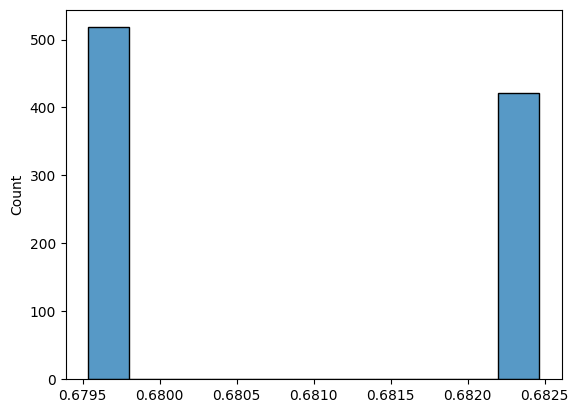

In [371]:
##Simple Models for Gain or Loss 

##Log Odds of Option A (certain) Only in Gain Condition 
logit_reg_gain = smf.logit('option_selected_A ~ 1', gain_cond).fit()
print("frame coeff:", logit_reg_gain.params['Intercept'])
print("frame p-vale:", logit_reg_gain.pvalues['Intercept'])
print(logit_reg_gain.summary())
##opposite framing effect 

##Log Odds of Option B (risky) Only in Loss Condition 
logit_reg_loss = smf.logit('option_selected_B ~ 1', loss_cond).fit()
print("frame coeff:", logit_reg_loss.params['Intercept'])
print("frame p-vale:", logit_reg_loss.pvalues['Intercept'])
print(logit_reg_loss.summary())

##With Controls  



In [ ]:
##table for gain / loss Comparison 
summary_options = [intercept_summary(logit_ratingappr_gain), 
                 intercept_summary(logit_ratingappr_rat_gain),
                 intercept_summary(logit_ratingappr_loss),
                 intercept_summary(logit_ratingappr_rat_loss)                 
                 ]
summary_options_df = pd.DataFrame(summary_options)

options_table = summary_options_df.T
print('\n')
print(tabulate(options_table, tablefmt = 'pretty', headers=["variable", "Gain Condition - All", "Gain Condition - Rationale Only","Loss Condition - All", "Loss Condition - Rationale Only" ]))


Hypotheses: The model type and test will impact the extent the AI exibits the framing effect 

In [209]:
##add in interaction term for test
logit_reg_test = smf.logit('option_selected_A ~ frame_gain * test', df_gpt3).fit()
print("frame coeff:", logit_reg_test.params[1])
print("frame p-vale:", logit_reg_test.pvalues[1])


Optimization terminated successfully.
         Current function value: 0.563945
         Iterations 23


/Users/annaking/Library/Python/3.9/lib/python/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


LinAlgError: Singular matrix

H5: A higher temperature will increase the framing effect observed in GPT-3.5 Turbo's choices.

In [ ]:
##add in interaction term for temp & model 

logit_reg_temptest = smf.logit('option_selected_cat ~ frame * test + frame * temperature ', df_gpt3).fit()
print("frame coeff:", logit_reg_temptest.params[1])
print("frame p-vale:", logit_reg_temptest.pvalues[1])
logit_reg_temptest.summary()
#framing effect is positive, but not significant 
##temperature has a positive and significant effect, suggesting that increasing temperature increases the odds of 'option_selected_cat'.
##interaction term frame[T.loss]:temperature is negative and significant, indicating that for loss-framed scenarios, increasing temperature decreases the odds of  selecting Option B compared to gain-framed scenarios.

H6: The model prompt conditions (risk, system role, and instructions) will impact the framing effect observed in GPT-3.5 Turbo's choices.

In [259]:
##Models for Instructions, Risk, and Sys Role 
    ###check 'moderate' 
    #standalone model 

logit_reg_ins = smf.logit('option_selected_A ~ frame_gain + C(instructions)', df_gpt3).fit()
print(logit_reg_ins.summary())

logit_reg_sys = smf.logit('option_selected_A ~ frame_gain + C(sys_role)', df_gpt3).fit()
print(logit_reg_sys.summary())

logit_reg_risk = smf.logit('option_selected_A ~ frame_gain + C(risk)', df_gpt3).fit()
print(logit_reg_risk.summary())

##add in interaction term for all prompt variables
logit_var_combined = smf.logit('option_selected_A ~ frame_gain * C(instructions) + frame_gain * C(risk) + frame_gain * C(sys_role)', df_gpt3).fit()
print(logit_var_combined.summary())


Optimization terminated successfully.
         Current function value: 0.607704
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:      option_selected_A   No. Observations:                 2412
Model:                          Logit   Df Residuals:                     2408
Method:                           MLE   Df Model:                            3
Date:                Mon, 14 Aug 2023   Pseudo R-squ.:                  0.1056
Time:                        21:18:58   Log-Likelihood:                -1465.8
converged:                       True   LL-Null:                       -1638.9
Covariance Type:            nonrobust   LLR p-value:                 9.893e-75
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                         0.5861      0.075      7.845      0.

In [310]:
logit_reg_ins = smf.logit('option_selected_A ~ frame_gain * C(instructions)', df_gpt3).fit()
print(logit_reg_ins.summary())

logit_reg_sys = smf.logit('option_selected_A ~ frame_gain * C(sys_role)', df_gpt3).fit()
print(logit_reg_sys.summary())

logit_reg_risk = smf.logit('option_selected_A ~ frame_gain * C(risk)', df_gpt3).fit()
print(logit_reg_risk.summary())

##add in interaction term for all prompt variables
logit_var_combined = smf.logit('option_selected_A ~ frame_gain * C(instructions) + frame_gain * C(risk) + frame_gain * C(sys_role)', df_gpt3).fit()
print(logit_var_combined.summary())

Optimization terminated successfully.
         Current function value: 0.604944
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:      option_selected_A   No. Observations:                 2412
Model:                          Logit   Df Residuals:                     2406
Method:                           MLE   Df Model:                            5
Date:                Tue, 15 Aug 2023   Pseudo R-squ.:                  0.1097
Time:                        15:50:55   Log-Likelihood:                -1459.1
converged:                       True   LL-Null:                       -1638.9
Covariance Type:            nonrobust   LLR p-value:                 1.563e-75
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
Intercept                                    0.6

In [311]:
# Assuming logit_reg, logit_reg_ins, logit_reg_var are your model outputs
table1 = create_compare_table(logit_reg, logit_reg_ins,logit_reg_sys,logit_reg_risk, logit_reg_var)
table1.fillna("--")
#print(table1)
print(tabulate(table1, headers = ("Basic", " + Instructions", "+ System Role", "+ Risk", "All" )))


                                          Basic               + Instructions    + System Role      + Risk             All
----------------------------------------  -----------------  -----------------  -----------------  -----------------  -----------------
frame_gain                                -1.142 (0.000***)  -1.365 (0.000***)  -1.522 (0.000***)  -1.037 (0.000***)  -1.241 (0.000***)
C(instructions)[T.chain]                  --                 0.250 (0.157)      --                 --                 -0.029 (0.837)
C(instructions)[T.task_order]             --                 -1.432 (0.000***)  --                 --                 -1.159 (0.000***)
C(sys_role)[T.neutral_system]             --                 --                 --                 --                 0.259 (0.064*)
C(sys_role)[T.human]                      --                 --                 -0.685 (0.000***)  --                 --
C(risk)[T.risk]                           --                 --                 -- 

In [308]:
##Tables to compare Results
def extract_from_model(model):
    """Extract coefficients, p-values from model object."""
    params = model.params
    pvals = model.pvalues
    std_err = model.bse
    return params, pvals, std_err 

def asterick(pval):
    if pval < 0.01:
        return '***'
    elif pval < 0.05:
        return '**'
    elif pval < 0.10:
        return '*'
    return ''


def create_compare_table(*models):
    """Create a table using coefficients, standard errors, and p-values."""
    # Define the desired ordering of the terms
    ordered_vars = ['frame_gain', 'C(instructions)[T.chain]', 'C(instructions)[T.task_order]', 
                    'C(sys_role)[T.neutral_system]', 'C(sys_role)[T.human]', 'C(risk)[T.risk]', 'Intercept']
    all_vars = set().union(*[set(model.params.index) for model in models])
    for var in all_vars:
        if var not in ordered_vars:
            ordered_vars.append(var)
    data = {'Variable': ordered_vars}
    for i, model in enumerate(models, start=1):
        params, pvals, std_err = extract_from_model(model)
        model_data = []
        for term in ordered_vars:
            if term in params:
                model_data.append(f"{params[term]:.3f} ({pvals[term]:.3f}{asterick(pvals[term])})")
            else:
                model_data.append("--")
        data[f'Model {i}'] = model_data

    df = pd.DataFrame(data).set_index('Variable')
    return df


# Assuming logit_reg, logit_reg_ins, logit_reg_var are your model outputs
table1 = create_compare_table(logit_reg, logit_reg_ins,logit_reg_sys,logit_reg_risk, logit_reg_var)
table1.fillna("--")
#print(table1)
print(tabulate(table1, headers = ("Basic", " + Instructions", "+ System Role", "+ Risk", "All" )))


                               Basic               + Instructions    + System Role      + Risk             All
-----------------------------  -----------------  -----------------  -----------------  -----------------  -----------------
frame_gain                     -1.142 (0.000***)  -1.236 (0.000***)  -1.163 (0.000***)  -1.157 (0.000***)  -1.241 (0.000***)
C(instructions)[T.chain]       --                 0.120 (0.319)      --                 --                 -0.029 (0.837)
C(instructions)[T.task_order]  --                 -1.179 (0.000***)  --                 --                 -1.159 (0.000***)
C(sys_role)[T.neutral_system]  --                 --                 --                 --                 0.259 (0.064*)
C(sys_role)[T.human]           --                 --                 -0.475 (0.000***)  --                 --
C(risk)[T.risk]                --                 --                 --                 0.233 (0.007***)   0.353 (0.002***)
Intercept                      0.121

In [ ]:
# Assuming logit_reg, logit_reg_ins, logit_reg_var are your model outputs
table1 = create_compare_table(logit_reg, logit_reg_ins,logit_reg_sys,logit_reg_risk, logit_reg_var)
table1.fillna("--")
#print(table1)
print(tabulate(table1, headers = ("Basic", " + Instructions", "+ System Role", "+ Risk", "All" )))


In [254]:
##Interaction with Test and Temp

##add in interaction term for temp
logit_reg_temp = smf.logit('option_selected_A ~ frame_gain *C(temperature) + frame_gain', df_gpt3).fit()
print("frame coeff:", logit_reg_temp.params['frame_gain'])
print("frame p-vale:", logit_reg_temp.pvalues['frame_gain'])
print(logit_reg_temp.summary())


Optimization terminated successfully.
         Current function value: 0.628467
         Iterations 5
frame coeff: -1.49362472361517
frame p-vale: 2.1055363172920415e-34
                           Logit Regression Results                           
Dep. Variable:      option_selected_A   No. Observations:                 2814
Model:                          Logit   Df Residuals:                     2810
Method:                           MLE   Df Model:                            3
Date:                Mon, 14 Aug 2023   Pseudo R-squ.:                 0.06587
Time:                        20:59:19   Log-Likelihood:                -1768.5
converged:                       True   LL-Null:                       -1893.2
Covariance Type:            nonrobust   LLR p-value:                 8.844e-54
                                       coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------

Optimization terminated successfully.
         Current function value: 0.440755
         Iterations 7
frame coeff: 1.0695059164404142
frame p-vale: 0.09188382689796289


<class 'statsmodels.iolib.summary.Summary'>
"""
                            Logit Regression Results                           
===============================================================================
Dep. Variable:     option_selected_cat   No. Observations:                  940
Model:                           Logit   Df Residuals:                      924
Method:                            MLE   Df Model:                           15
Date:                 Sat, 05 Aug 2023   Pseudo R-squ.:                  0.2962
Time:                         01:43:28   Log-Likelihood:                -414.31
converged:                        True   LL-Null:                       -588.65
Covariance Type:             nonrobust   LLR p-value:                 3.956e-65
===============================================================================================================================================================================
                                                                                                                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                                      -3.2113      0.515     -6.237      0.000      -4.220      -2.202
frame[T.loss]                                                                                                   1.0695      0.635      1.686      0.092      -0.174       2.313
test[T.['combo 2', 'system_message_hum', 'user_message_baseline1', 'human']]                                   -0.2635      0.705     -0.374      0.709      -1.645       1.118
test[T.['combo 3', 'system_message_risk', 'user_message_baseline1', 'risk system']]                             1.5458      0.560      2.760      0.006       0.448       2.643
test[T.['combo 5', 'system_message_hum_json', 'user_message_taskord', 'hum + task order']]                      3.7690      0.576      6.541      0.000       2.640       4.898
test[T.['combo 5B', 'system_message_risk_json', 'user_message_taskord', 'risk + task order']]                   3.0909      0.556      5.556      0.000       2.000       4.181
test[T.['combo 6', 'system_message_1', 'user_message_chain', 'flag for re-run']]                                0.8187      0.592      1.383      0.167      -0.341       1.979
test[T.['combo 6B', 'system_message_risk', 'user_message_chain', 'risk + chain']]                               1.4554      0.563      2.587      0.010       0.353       2.558
frame[T.loss]:test[T.['combo 2', 'system_message_hum', 'user_message_baseline1', 'human']]                     -0.5093      0.910     -0.559      0.576      -2.294       1.275
frame[T.loss]:test[T.['combo 3', 'system_message_risk', 'user_message_baseline1', 'risk system']]              -0.9719      0.715     -1.360      0.174      -2.373       0.429
frame[T.loss]:test[T.['combo 5', 'system_message_hum_json', 'user_message_taskord', 'hum + task order']]       -0.4983      0.731     -0.681      0.496      -1.932       0.935
frame[T.loss]:test[T.['combo 5B', 'system_message_risk_json', 'user_message_taskord', 'risk + task order']]    -0.1304      0.707     -0.185      0.854      -1.515       1.254
frame[T.loss]:test[T.['combo 6', 'system_message_1', 'user_message_chain', 'flag for re-run']]                 -0.6028      0.753     -0.800      0.424      -2.079       0.873
frame[T.loss]:test[T.['combo 6B', 'system_message_risk', 'user_message_chain', 'risk + chain']]                -1.5772      0.749     -2.107      0.035      -3.045      -0.110
temperature                                                                                                     1.8456      0.386      4.780      0.000       1.089       2.602
frame[T.loss]:temperature                                       

In [250]:
##This model aims to examine how the combination of the frame condition and the temperature setting influences the likelihood of selecting Proposal B (risky option).
print("Outcome: The framing effect is stronger or weaker at different temperature settings.")

#logit_reg_T = smf.logit('option_selected_cat ~ frame + temp_var', df_gpt3).fit()
logit_reg_T = smf.logit('option_selected_A ~ frame_gain * C(temperature) + frame_gain', df_gpt3).fit()
logit_reg_T.summary()


Outcome: The framing effect is stronger or weaker at different temperature settings.
Optimization terminated successfully.
         Current function value: 0.628467
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:      option_selected_A   No. Observations:                 2814
Model:                          Logit   Df Residuals:                     2810
Method:                           MLE   Df Model:                            3
Date:                Mon, 14 Aug 2023   Pseudo R-squ.:                 0.06587
Time:                        18:37:21   Log-Likelihood:                -1768.5
converged:                       True   LL-Null:                       -1893.2
Covariance Type:            nonrobust   LLR p-value:                 8.844e-54
====================================================================================================
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                            0.0560      0.075      0.748      0.454      -0.091       0.203
C(temperature)[T.0.7]                0.1294      0.106      1.219      0.223      -0.079       0.337
frame_gain                          -1.4936      0.122    -12.232      0.000      -1.733      -1.254
frame_gain:C(temperature)[T.0.7]     0.6345      0.164      3.860      0.000       0.312       0.957
====================================================================================================
"""

##### Robustness Checks

In [253]:
### Check for collinarity in prompt variables 

from statsmodels.stats.outliers_influence import variance_inflation_factor
# Define the predictor variables based on your model
X = df_gpt3_w_dummy[[
    'frame_gain', 'temperature', 'sys_role', 'instructions', 
    'risk']
]

X = sm.add_constant(X)

# Drop rows with missing or infinite values before calculating VIF
X = X.replace([np.inf, -np.inf], np.nan).dropna()

# Create a new data frame for the VIF data
vif_data = pd.DataFrame()
vif_data['feature'] = X.columns

# Calculate and add the VIF to the data frame
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

print(vif_data)




TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [ ]:
lin_reg = sm.OLS.from_formula('rating_num ~ frame + ', data = df_gpt3 ).fit()
print("frame coeff:", lin_reg.params[1])
print("frame p-vale:", lin_reg.pvalues[1])
##print("\nsignficicant effect? --> ", sig_effect(lin_reg.pvalues[1]))

print("\n\n\n",lin_reg.summary())


frame coeff: 0.0652113652113649
frame p-vale: 0.6447190740223837



                             OLS Regression Results                            
Dep. Variable:             rating_num   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.2128
Date:                Fri, 04 Aug 2023   Prob (F-statistic):              0.645
Time:                        19:47:53   Log-Likelihood:                -1870.6
No. Observations:                 871   AIC:                             3745.
Df Residuals:                     869   BIC:                             3755.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------

#### Ordinal

- H1.2: The strength of preference, as indicated by 'rating_num', will vary depending on whether the scenario is framed as a gain or loss.